In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

Using TensorFlow backend.


* Overfitting is definately the biggest challenge
* Most of the techniques to prevent overfitting is placed under regularization
* Regularization reduce test error
#### Adding dropout to prevent overfitting
* One of regularization method
* when using a dropout of 0.5, the network has to see each example twice before the connection is learned

In [2]:
data = pd.read_csv('Bike/hour.csv')

In [4]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
# Feature engineering
ohe_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for feature in ohe_features:
    dummies = pd.get_dummies(data[feature], prefix=feature, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

drop_features = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data = data.drop(drop_features, axis=1)

In [6]:
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
norm_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for feature in norm_features:
    mean, std = data[feature].mean(), data[feature].std()
    scaled_features[feature] = [mean, std]
    data.loc[:, feature] = (data[feature] - mean)/std

In [8]:
data.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.956312,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.823998,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.868103,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.972851,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-1.039008,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Split data into train, test & validate

In [9]:
# Save the final month for testing
test_data = data[-31*24:]
data = data[:-31*24]
# Extract the target field
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
# Create a validation set (based on the last )
X_train, y_train = features[:-30*24], targets[:-30*24]
X_val, y_val = features[-30*24:], targets[-30*24:]

#### Network architecture

In [10]:
model = Sequential()
model.add(Dense(250, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [12]:
n_epochs = 4000
batch_size = 1024

history = model.fit(X_train.values, y_train['cnt'], 
                 validation_data=(X_val.values, y_val['cnt']), 
                 batch_size=batch_size, epochs=n_epochs, verbose=0
                )


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 250)               14250     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               37650     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 60,751
Trainable params: 60,751
Non-trainable params: 0
_________________________________________________________________


In [17]:
len(data.columns.tolist())

57

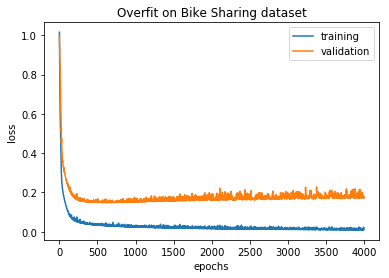

In [18]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label='training')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
plt.title('Overfit on Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

In [19]:

print('Minimum loss: ', min(history.history['val_loss']), 
      '\nAfter ', np.argmin(history.history['val_loss']), ' epochs')

Minimum loss:  0.147792205215 
After  677  epochs


In [20]:
model_reg = Sequential()
model_reg.add(Dense(250, input_dim=X_train.shape[1], activation='relu',
            kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(150, activation='relu'))
model_reg.add(Dense(50, activation='relu'))
model_reg.add(Dense(25, activation='relu',
            kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(1, activation='linear'))

# Compile model
model_reg.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [21]:
history_reg = model_reg.fit(X_train.values, y_train['cnt'], 
validation_data=(X_val.values, y_val['cnt']), 
                 batch_size=batch_size, epochs=n_epochs, verbose=0
                )


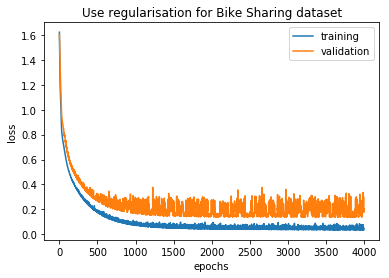

In [22]:
plt.plot(np.arange(len(history_reg.history['loss'])), history_reg.history['loss'], label='training')
plt.plot(np.arange(len(history_reg.history['val_loss'])), history_reg.history['val_loss'], label='validation')
plt.title('Use regularisation for Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()